In [7]:
import importlib
import utils  # or the name of your module
importlib.reload(utils)
from deeptime.clustering import KMeans
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
import pyemma.coordinates as coor
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from read_data import *

In [34]:
deeptime.__version__

'0.4.5'

In [84]:
protein = 'chignolin'

coords = xyz_to_numpy(f'{protein}_short.xyz')
dists = get_inter_bead_distances(coords)
#data = coor.source(coords).get_output()    # Write the coordinates in the pyemma format
#traj = np.squeeze(np.array(data))
traj = dists
traj.shape

(20000, 45)

# Choosing lag time for tICA
...

0
1
2


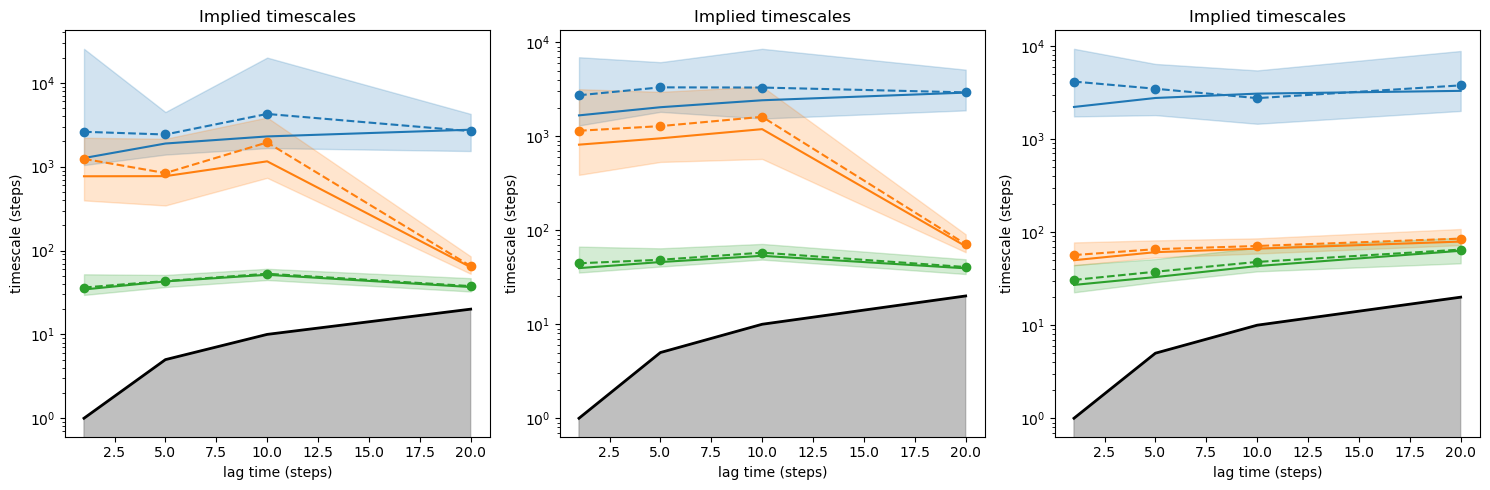

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, n_clusters in enumerate([50, 100, 200]):
    clustering = KMeans(n_clusters=n_clusters).fit_fetch(traj)
    dtraj = clustering.transform(traj)

    models = []
    lagtimes = [1, 5, 10, 20]
    for lagtime in lagtimes:
        counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(dtraj)
        models.append(BayesianMSM(n_samples=n_clusters).fit_fetch(counts))

    its_data = implied_timescales(models)

    plot_implied_timescales(its_data, n_its=3, ax=ax[i])
    ax[i].set_yscale('log')
    ax[i].set_title('Implied timescales')
    ax[i].set_xlabel('lag time (steps)')
    ax[i].set_ylabel('timescale (steps)')
    print(i)

fig.tight_layout()

In [82]:
from deeptime.decomposition import TICA
importlib.reload(deeptime.plots)
from deeptime.plots import plot_density
from deeptime.plots import plot_energy2d
from deeptime.util import energy2d

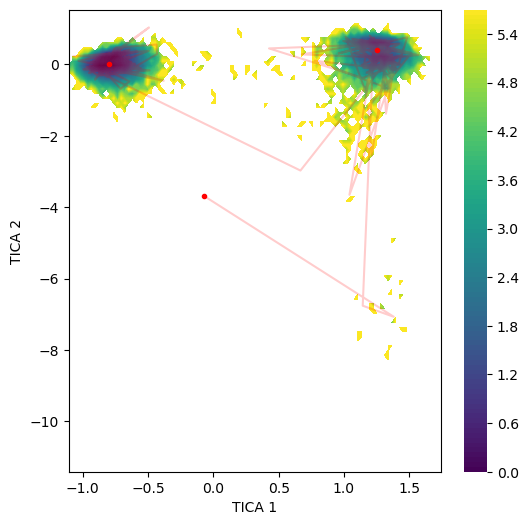

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
estimator = TICA(lagtime=10, dim=3).fit(traj)
model = estimator.fetch_model()
tica_traj = model.transform(traj)

energy = energy2d(tica_traj[:, 0], tica_traj[:, 1], bins=100)
plot_energy2d(energy, ax=ax)
plt.plot(tica_traj[::100, 0], tica_traj[::100, 1], 'r', markersize=0.1, alpha=0.2)
plt.plot(tica_traj[0, 0], tica_traj[0, 1], 'r.')
plt.xlabel('TICA 1')
plt.ylabel('TICA 2')

plt.plot([1.25, -0.8], [0.4, 0.0], 'r.')

#plot_density(tica_traj[:,0], tica_traj[:,1], n_bins=100)
'''plt.plot([0.7], [-0.35], 'r.')
plt.plot([-0.7], [0.1], 'r.')
plt.plot([-1.15], [-0.25], 'r.')
plt.xlabel('TICA 1')
plt.ylabel('TICA 3')'''
'''ax.set_xlim(None, 2)
ax.set_ylim(None, 2.5)'''
plt.savefig(f'tica_{protein}.png', dpi=300)

In [90]:
# Find representatives of the conformotions
def find_representative(tica_traj, minima):
    distances = np.linalg.norm(tica_traj - minima, axis=1)
    print(distances.shape)
    return np.argmin(distances)

minima1 = np.array([-0.8, 0.0])
minima2 = np.array([1.25, 0.4])
#minima3 = np.array([-0.4, 8.0])

repr1 = find_representative(tica_traj[:,[0,1]], minima1)
repr2 = find_representative(tica_traj[:,[0,1]], minima2)
#repr3 = find_representative(tica_traj[:,[0,1]], minima3)
repr1, repr2#, repr3

(20000,)
(20000,)


(8598, 5898)

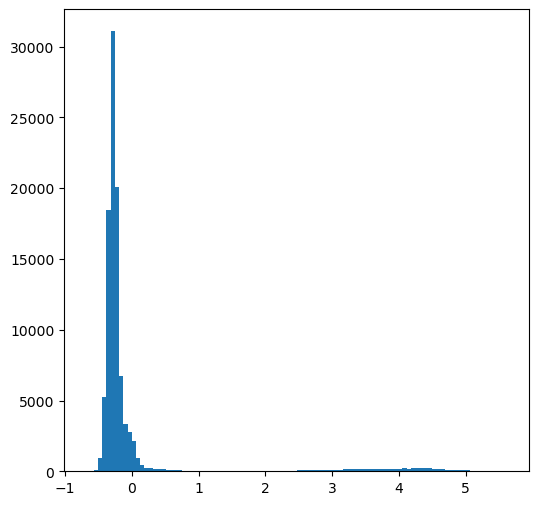

In [21]:
tica1 = tica_traj[:, 0]
tica2 = tica_traj[:, 1]
tica3 = tica_traj[:, 2]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#ax = plt.hist2d(tica2, tica1, bins=100, density=True, cmap='Blues')
ax = plt.hist(tica1, bins=100)

In [10]:
protein = 'complexin_2'
coords = xyz_to_numpy(f'{protein}_short.xyz')
helicity, helix_mask = get_per_residue_helicity(coords)

<Axes: title={'center': 'Per-residue helicity of complexin_2'}, xlabel='Residue index', ylabel='Helicity'>

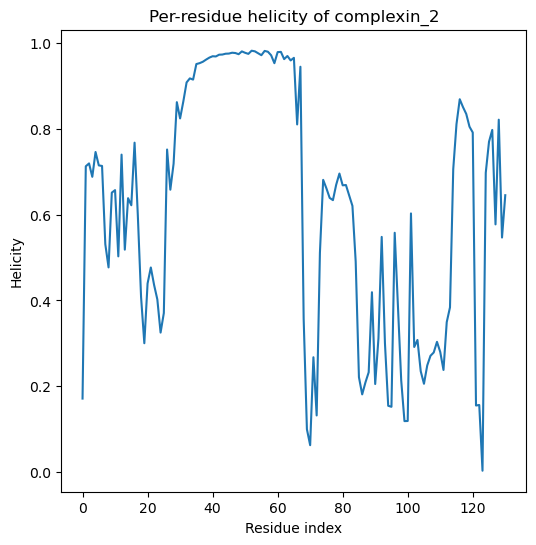

In [11]:
def plot_helicity(helicity, protein, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.plot(helicity, color='C0')
    ax.set_xlabel('Residue index')
    ax.set_ylabel('Helicity')
    ax.set_title(f'Per-residue helicity of {protein}')
    return ax

plot_helicity(helicity, protein)

In [75]:
protein = 'chignolin'

coords = xyz_to_numpy(f'{protein}_short.xyz')
dists = get_inter_bead_distances(coords)

(64,)

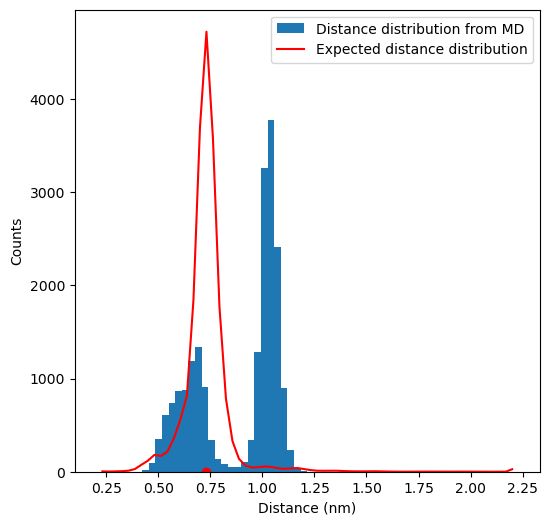

In [91]:
dist12 = dists[:,13]

coords, bins, pae, dgram, seq_len, seq = read_data(protein)
for i in range(seq_len):
    for j in range(seq_len):
        dgram[i, j] = dgram[i, j] - np.max(dgram[i, j])
    
probs12 = np.exp(dgram[1,6]) / np.sum(np.exp(dgram[1,6]))
bins = np.linspace(0.231, 2.2, 64)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(dist12, bins=64, range=(0.2, 2.231), density=False, label='Distance distribution from MD')
ax.plot(bins, probs12 * dist12.shape[0], 'r', label='Expected distance distribution')
ax.plot(dist12[0], 0, 'ro')
ax.set_xlabel('Distance (nm)')
ax.set_ylabel('Counts')
ax.legend()
probs12.shape